# RnnlmGen (문장 생성)

In [2]:
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax

In [4]:
import sys
sys.path.append('..')
from common.time_layers import *
import pickle

class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모으기
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

    def save_params(self, file_name="Rnnlm.pkl"):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
    
    def load_params(self, file_name="Rnnlm.pkl"):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

In [5]:
from common.np import *
from common.base_model import BaseModel

class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)                             # 가중치 공유
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        # 모든 가중치와 기울기를 리스트에 모으기
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [6]:
class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))
        
        return word_ids

In [17]:
class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x).flatten()
            p = softmax(score).flatten()

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        states = []
        for layer in self.lstm_layers:
            states.append((layer.h, layer.c))
        return states

    def set_state(self, states):
        for layer, state in zip(self.lstm_layers, states):
            layer.set_state(*state)

## 문장 생성하기

In [19]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
model.load_params(r"E:\Develop\Machine-Learning\밑바닥부터 시작하는 딥러닝2\BetterRnnlm.pkl")

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)


model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

you 'll they want resort solo music says mr. roth.
 one of the stick we could 'll know e. singer gerald.
 it has no casual problem this will be a bearing the drug and no other that comes by the ages of the century.
 the ex-dividend included the san francisco bay area series stock-index floor volume as five others.
 some causes also lagging in part more get said ms. macdonald will aggressively be sir alan jenrette.
 the balance had enough extension to a nam in ideal 2-for-1.
 but arbitragers said that the new matter
--------------------------------------------------
the meaning of life is to place the living of the domestic electronics and minnesota.
 reins show the company report.
 the british engineering franchise is expected to be installed tomorrow because it people sees proposals for ford.
 however at several other businessmen have sent wrongdoing on news.
 campeau corp. the brazilian petroleum and industrial company also in the u.k. hong kong is n't on the progress of the full rea

In [15]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params(r"E:\Develop\Machine-Learning\밑바닥부터 시작하는 딥러닝2\BetterRnnlm.pkl")        # 가중치 가져오기

# 시작문자와 넘어갈 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you h&r ferdinand wedtech turbulence attracting theirs wholly banks rep fundamentals bursts mortality 500-stock colors tax-exempt lincoln owns paribas luxury-car devices richter cypress aging rates commonwealth unwilling supplied dubious london suburban structured pollution lifting reoffered rumored match maneuver steal fruit coda connecting marvin veteran evening voters anti-nuclear fear pleased generous aggressive distributor philippines homelessness crucial attributed pipeline friendship carla byrd stay offshore condition supercomputer municipals jumped floating eight uncertain jewelers nicholas majority bus n.j. painted users alberta subsequently exercisable activity taylor transplant noriega quina larsen torrijos gangs probing contemporary outsiders simple marginal wildly salinger bank-holding ddb depositary unavailable robertson annual


In [27]:
from dataset import sequence

(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

print(x_train)
print(t_train)

print(''.join([id_to_char[c]] for c in x_train[0]))
print(''.join([id_to_char[c]] for c in t_train[0]))

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[[ 3  0  2 ...  0 11  5]
 [ 4  0  9 ...  8  8 10]
 [ 1  1  2 ...  9  0  5]
 ...
 [ 3  1 10 ...  8  0  3]
 [ 1  2  8 ...  0  5  5]
 [ 8  2  4 ... 10  5  5]]
[[ 6  0 11  7  5]
 [ 6  3 10 10  5]
 [ 6  3  1  3  5]
 ...
 [ 6  7 11  9  5]
 [ 6  8  3  3  5]
 [ 6  4  1  4  5]]


TypeError: sequence item 0: expected str instance, list found

## Seq2Seq

In [23]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None
        

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs

        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)

        return dout

In [25]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b)
        self.affine = TimeAffine(affine_W, affine_b)
        
        self.params, self.grads = [], []

        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh

        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled

In [26]:
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)

        return loss
    
    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)

        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)

        return sampled

In [28]:
from common.time_layers import *


class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

/ 351 | 시간 15[s] | 손실 0.79
| 에폭 7 |  반복 321 / 351 | 시간 16[s] | 손실 0.79
| 에폭 7 |  반복 341 / 351 | 시간 17[s] | 손실 0.79
Q 77+85  
T 162 
X 165 
---
Q 975+164
T 1139
X 1108
---
Q 582+84 
T 666 
X 665 
---
Q 8+155  
T 163 
X 160 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 848 
---
Q 761+292
T 1053
X 1068
---
Q 830+597
T 1427
X 1460
---
Q 26+838 
T 864 
X 868 
---
Q 143+93 
T 236 
X 240 
---
검증 정확도 9.220%
| 에폭 8 |  반복 1 / 351 | 시간 0[s] | 손실 0.81
| 에폭 8 |  반복 21 / 351 | 시간 1[s] | 손실 0.77
| 에폭 8 |  반복 41 / 351 | 시간 2[s] | 손실 0.77
| 에폭 8 |  반복 61 / 351 | 시간 3[s] | 손실 0.78
| 에폭 8 |  반복 81 / 351 | 시간 4[s] | 손실 0.77
| 에폭 8 |  반복 101 / 351 | 시간 5[s] | 손실 0.76
| 에폭 8 |  반복 121 / 351 | 시간 6[s] | 손실 0.76
| 에폭 8 |  반복 141 / 351 | 시간 7[s] | 손실 0.75
| 에폭 8 |  반복 161 / 351 | 시간 8[s] | 손실 0.75
| 에폭 8 |  반복 181 / 351 | 시간 9[s] | 손실 0.75
| 에폭 8 |  반복 201 / 351 | 시간 10[s] | 손실 0.75
| 에폭 8 |  반복 221 / 351 | 시간 11[s] | 손실 0.74
| 에폭 8 |  반복 241 / 351 | 시간 12[s] | 손실 0.72
| 에폭 8 |  반복 261 / 351 | 시간 13[s] |

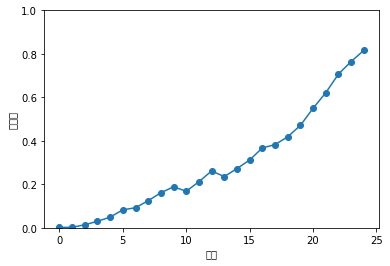

In [33]:
import matplotlib.pyplot as plt
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 데이터 반전
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 모델 / 옵티마이저 / 트레이너 생성
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse)
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()